# Mathematical Underpinnings - Lab 6

In [1]:
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
np.random.seed(123)

## Useful functions

In [3]:
def discetize_2bins(X):
    X_discrete = 1*(X >= 0)
    return X_discrete

In [4]:
def conditional_permutation(X, Z):
    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    X_b = np.zeros(n)

    for i in range(n_z_values):
        z_value_tmp = z_values[i]
        X_b[Z == z_value_tmp] = np.random.permutation(X[Z == z_value_tmp])

    return X_b

In [5]:
def conditional_mutual_information(X, Y, Z):
    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    cmi = 0

    for i in range(n_z_values):
        z_value_tmp = z_values[i]
        z_condition = (Z == z_value_tmp)

        X_z = X[z_condition]
        Y_z = Y[z_condition]

        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition)/n

        cmi += p_z*mi_XY_z

    return cmi

In [6]:
# II(X;Y;Z)
def interaction_information(X, Y, Z):
    return conditional_mutual_information(X, Y, Z) - mutual_info_score(X, Y)

In [7]:
# II(X;Y;Z1;Z2)
def interaction_information2(X, Y, Z1, Z2):
    Z_1_and_2 = 2*Z2 + Z1
    return interaction_information(X, Y, Z_1_and_2) - interaction_information(X, Y, Z1) - interaction_information(X, Y, Z2)

## Task 1

In [8]:
def secmi2(X, Y, Z):
    mi = mutual_info_score(X, Y)
    ii = sum(
        interaction_information(X, Y, Z[:, i]) 
        for i in range(Z.shape[1])
    )
    
    return mi + ii

def secmi3(X, Y, Z):
    secmi_2 = secmi2(X, Y, Z)
    ii_2 = sum(
        interaction_information2(X, Y, Z[:, i], Z[:, j]) 
        for i in range(Z.shape[1]) 
        for j in range(i+1, Z.shape[1])
    )
    
    return secmi_2 + ii_2

### a)

In [9]:
def cond_indep_test_permutation(X, Y, Z, B=50, stat='cmi'):

    n_col_Z = Z.shape[1]
    Z_1dim = np.dot(Z, 2**np.linspace(0, n_col_Z-1, n_col_Z))

    if stat == "cmi":
        stat_value = conditional_mutual_information(X, Y, Z_1dim)
    if stat == "secmi2":
        stat_value = secmi2(X, Y, Z)
    if stat == "secmi3":
        stat_value = secmi3(X, Y, Z)

    condition_p_value = 0
    for b in range(B):
        X_b = conditional_permutation(X, Z_1dim)

        if stat == "cmi":
            stat_value_b = conditional_mutual_information(X_b, Y, Z_1dim)
        if stat == "secmi2":
            stat_value_b = secmi2(X_b, Y, Z)
        if stat == "secmi3":
            stat_value_b = secmi3(X_b, Y, Z)

        if stat_value <= stat_value_b:
            condition_p_value += 1

    p_value = (1 + condition_p_value)/(1 + B)

    return 2*len(X)*stat_value, p_value

### b)

In [10]:
def draw_data(n=100):
    Y = np.random.normal(0, 1, size=n)
    Y = discetize_2bins(Y)
    
    Z1 = np.random.normal(2*(Y - 0.5), 1, size=n)
    Z1 = discetize_2bins(Z1)
    Z2 = np.random.normal(2*(Y - 0.5), 1, size=n)
    Z2 = discetize_2bins(Z2)
    Z3 = np.random.normal(2*(Y - 0.5), 1, size=n)
    Z3 = discetize_2bins(Z3)
    
    X = np.random.normal(2*(Z1 - 0.5), 1, size=n)
    X = discetize_2bins(X)
    
    return X, Y, Z1, Z2, Z3

In [11]:
from multiprocessing import Pool

N = 100

def run_test(i, data_generator=draw_data):
    np.random.seed(i)
    X, Y, Z1, Z2, Z3 = data_generator(100)
    results = pd.DataFrame()
    for stat in ['cmi', 'secmi2', 'secmi3']:
        test1 = cond_indep_test_permutation(
            X, Y, np.column_stack((Z1, Z2)), stat=stat
        )
        test2 = cond_indep_test_permutation(
            X, Y, np.column_stack((Z2, Z3)), stat=stat
        )

        results = pd.concat([
            results,
            pd.DataFrame({
                'stat': stat,
                'p_value_1': test1[1],
                'stat_value_1': test1[0],
                'p_value_2': test2[1],
                'stat_value_2': test2[0]
            }, index=[0])
        ])
    return results

In [12]:
with Pool() as p:
    results = pd.concat(p.map(run_test, range(N)))

In [13]:
results['reject_test_1'] = results['p_value_1'] < 0.05
results['reject_test_2'] = results['p_value_2'] < 0.05

In [14]:
results_pivot = results.melt(
    id_vars='stat', value_vars=['reject_test_1', 'reject_test_2'], 
    var_name='test', value_name='reject'
).groupby(
    ['stat', 'test']
).sum().reset_index()

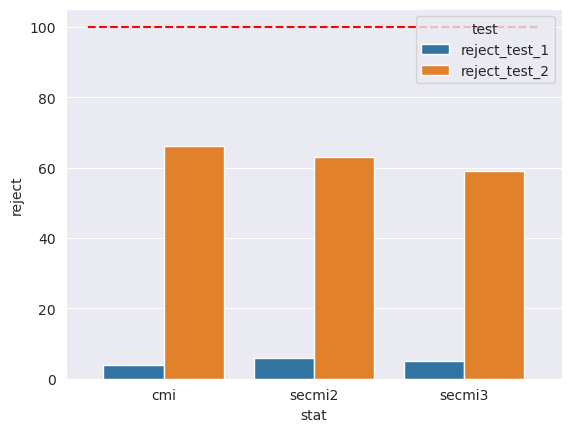

In [15]:
sns.barplot(
    x='stat', y='reject', hue='test', data=results_pivot
)
plt.hlines(N, -0.5, 2.5, 'red', linestyles='dashed')
plt.show()

### c)

In [16]:
def draw_data_2(n=100):
    X = np.random.normal(0, 1, size=n)
    X = discetize_2bins(X)
    Z1 = np.random.normal(0, 1, size=n)
    Z1 = discetize_2bins(Z1)
    Z2 = np.random.normal(0, 1, size=n)
    Z2 = discetize_2bins(Z2)
    Z3 = np.random.normal(0, 1, size=n)
    Z3 = discetize_2bins(Z3)
    
    sum_modulo_2 = (X + Z1 + Z2) % 2
    Y = np.random.binomial(1, np.where(sum_modulo_2 == 1, 0.8, 0.2))
    return X, Y, Z1, Z2, Z3

In [17]:
from functools import partial

N = 100

with Pool() as p:
    results_2 = pd.concat(
        p.map(partial(run_test, data_generator=draw_data_2), range(N))
    )

In [18]:
results_2['reject_test_1'] = results_2['p_value_1'] < 0.05
results_2['reject_test_2'] = results_2['p_value_2'] < 0.05

In [19]:
results_pivot = results_2.melt(
    id_vars='stat', value_vars=['reject_test_1', 'reject_test_2'],
    var_name='test', value_name='reject'
).groupby(
    ['stat', 'test']
).sum().reset_index()

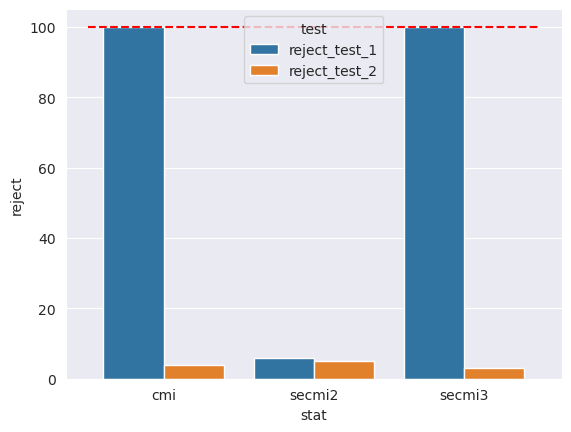

In [20]:
sns.barplot(
    x='stat', y='reject', hue='test', data=results_pivot
)
plt.hlines(N, -0.5, 2.5, 'red', linestyles='dashed')
plt.show()

## Task 2
 
in R